# 15.S52 AI in Finance Final Project

Priscilla Clark, Siddharth Mehta, Derek Wang

## Load and prepare data

Join macro features to loan details while preventing look-ahead bias with interest rates

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
# Load data
mortgage_df = pd.read_csv('mortgage_data.csv')
hpi_df = pd.read_csv('hpi_state.csv')
rate_df = pd.read_csv('rate.csv')

In [56]:
hpi_df

,year,quarter,state,state_code,state_full,HPI_state
0,1975,1,AK,2,Alaska,61.580002
1,1975,2,AK,2,Alaska,63.060001
2,1975,3,AK,2,Alaska,67.699997
3,1975,4,AK,2,Alaska,66.779999
4,1976,1,AK,2,Alaska,73.070000
...,...,...,...,...,...,...
8971,2017,4,WY,56,Wyoming,309.510010
8972,2018,1,WY,56,Wyoming,315.810000
8973,2018,2,WY,56,Wyoming,316.209990
8974,2018,3,WY,56,Wyoming,320.450010


In [57]:
rate_df

,year,month,FRM30_rate,treasury_3mon_rate
0,2000,1,8.2100,5.32
1,2000,2,8.3250,5.55
2,2000,3,8.2400,5.69
3,2000,4,8.1525,5.66
4,2000,5,8.5150,5.79
...,...,...,...,...
226,2018,11,4.8660,2.33
227,2018,12,4.6375,2.37
228,2019,1,4.4640,2.37
229,2019,2,4.3700,2.39


In [58]:
mortgage_df

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,dti,cscore_b,mi_pct,fthb_flg,num_bo,num_unit,state
0,FD,F100Q1023070,2000,1,0,4/1/2000,8.500,204000,79,79,37,643,0,N,2,1,AK
1,FD,F100Q1039162,2000,1,0,5/1/2000,8.375,100000,34,34,19,796,0,N,2,1,AK
2,FD,F100Q1050054,2000,1,0,3/1/2000,8.500,173000,95,95,43,698,25,N,2,1,AK
3,FD,F100Q1002153,2000,1,0,3/1/2000,8.125,137000,80,80,28,716,0,N,2,1,AL
4,FD,F100Q1005553,2000,1,0,3/1/2000,8.250,92000,95,95,42,680,30,N,2,1,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295832,FN,611000000000.0,2006,4,1,1/1/2007,6.250,123000,72,72,26,639,0,N,2,1,WY
295833,FN,661000000000.0,2006,4,0,12/1/2006,6.000,150000,64,64,45,720,0,Y,2,1,WY
295834,FN,665000000000.0,2006,4,1,2/1/2007,6.625,147000,80,90,52,691,0,N,1,1,WY
295835,FN,769000000000.0,2006,4,0,12/1/2006,6.250,176000,60,60,13,781,0,N,2,1,WY


In [59]:
# Get previous quarter for HPI join
mortgage_df['HPI_quarter'] = mortgage_df['Quarter_orig'] - 1
mortgage_df['HPI_year'] = mortgage_df['Year_orig']
mortgage_df.loc[mortgage_df['HPI_quarter'] == 0, 'HPI_quarter'] = 4
mortgage_df.loc[mortgage_df['HPI_quarter'] == 4, 'HPI_year'] = mortgage_df['Year_orig'] - 1

In [60]:
# Calculate rate month (first month of quarter - 1)
mortgage_df['rate_month'] = (mortgage_df['Quarter_orig'] - 1) * 3
mortgage_df['rate_year'] = mortgage_df['Year_orig']
mortgage_df.loc[mortgage_df['rate_month'] == 0, 'rate_month'] = 12
mortgage_df.loc[mortgage_df['rate_month'] == 12, 'rate_year'] = mortgage_df['Year_orig'] - 1

In [61]:
# Display distinct values for specified columns
distinct_values = mortgage_df[['Year_orig', 'Quarter_orig', 'HPI_quarter', 'HPI_year','rate_month','rate_year']].drop_duplicates()
distinct_values

,Year_orig,Quarter_orig,HPI_quarter,HPI_year,rate_month,rate_year
0,2000,1,4,1999,12,1999
3510,2000,2,1,2000,3,2000
9232,2000,3,2,2000,6,2000
15417,2000,4,3,2000,9,2000
20637,2001,1,4,2000,12,2000
25373,2001,2,1,2001,3,2001
32664,2001,3,2,2001,6,2001
39575,2001,4,3,2001,9,2001
45066,2002,1,4,2001,12,2001
49829,2002,2,1,2002,3,2002


In [62]:
# Join with previous quarter's HPI data
final_df = mortgage_df.merge(
    hpi_df[['year', 'quarter', 'state', 'HPI_state']],
    left_on=['HPI_year', 'HPI_quarter', 'state'],
    right_on=['year', 'quarter', 'state'],
    how='left'
)

# Join with rate data
final_df = final_df.merge(
    rate_df[['year', 'month', 'FRM30_rate', 'treasury_3mon_rate']],
    left_on=['rate_year', 'rate_month'],
    right_on=['year', 'month'],
    how='left'
)

In [63]:
print("\nSample of 5 loans to verify the joins:")
sample_cols = ['Year_orig', 'Quarter_orig', 'state', 'HPI_state', 'FRM30_rate', 'treasury_3mon_rate']
print(final_df[sample_cols].head().to_string())

print("\nShape of final dataset:", final_df.shape)


Sample of 5 loans to verify the joins:
   Year_orig  Quarter_orig state  HPI_state  FRM30_rate  treasury_3mon_rate
0       2000             1    AK     170.08         NaN                 NaN
1       2000             1    AK     170.08         NaN                 NaN
2       2000             1    AK     170.08         NaN                 NaN
3       2000             1    AL     208.33         NaN                 NaN
4       2000             1    AL     208.33         NaN                 NaN

Shape of final dataset: (295837, 28)


In [64]:
# Check for missing HPI_state values
loans_without_hpi = final_df[final_df['HPI_state'].isnull()]

distinct_values_missingHPI = loans_without_hpi[['state']].drop_duplicates()
distinct_values_missingHPI

,state
2825,PR
4919,GU
61832,VI


In [65]:
final_df

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,...,HPI_year,rate_month,rate_year,year_x,quarter,HPI_state,year_y,month,FRM30_rate,treasury_3mon_rate
0,FD,F100Q1023070,2000,1,0,4/1/2000,8.500,204000,79,79,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
1,FD,F100Q1039162,2000,1,0,5/1/2000,8.375,100000,34,34,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
2,FD,F100Q1050054,2000,1,0,3/1/2000,8.500,173000,95,95,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
3,FD,F100Q1002153,2000,1,0,3/1/2000,8.125,137000,80,80,...,1999,12,1999,1999.0,4.0,208.33,NaN,NaN,NaN,NaN
4,FD,F100Q1005553,2000,1,0,3/1/2000,8.250,92000,95,95,...,1999,12,1999,1999.0,4.0,208.33,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295832,FN,611000000000.0,2006,4,1,1/1/2007,6.250,123000,72,72,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295833,FN,661000000000.0,2006,4,0,12/1/2006,6.000,150000,64,64,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295834,FN,665000000000.0,2006,4,1,2/1/2007,6.625,147000,80,90,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295835,FN,769000000000.0,2006,4,0,12/1/2006,6.250,176000,60,60,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81


In [66]:
# Calculate missing value statistics
total_loans = len(final_df)
missing_stats = pd.DataFrame({
    'Missing_Count': final_df[['HPI_state', 'FRM30_rate', 'treasury_3mon_rate']].isnull().sum(),
    'Missing_Percentage': (final_df[['HPI_state', 'FRM30_rate', 'treasury_3mon_rate']].isnull().sum() / total_loans * 100).round(2)
})

print("Total number of loans:", total_loans)
print("\nMissing value statistics:")
print(missing_stats)

Total number of loans: 295837

Missing value statistics:
                    Missing_Count  Missing_Percentage
HPI_state                     406                0.14
FRM30_rate                   8854                2.99
treasury_3mon_rate           8854                2.99


In [67]:
# Handle nulls
# Option 1: Drop rows with nulls
df_clean = final_df.dropna(subset=['HPI_state', 'FRM30_rate', 'treasury_3mon_rate'])

In [68]:
# Calculate missing value statistics for all columns
total_loans = len(df_clean)
missing_stats = pd.DataFrame({
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / total_loans * 100).round(2)
})

# Only show columns with missing values
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("Total number of loans:", total_loans)
print("\nColumns with missing values:")
print(missing_stats)

Total number of loans: 286591

Columns with missing values:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


## Baseline logistical regression (only mortgage loan features)

In [69]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year']
df = mortgage_df.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

AUC: 0.738


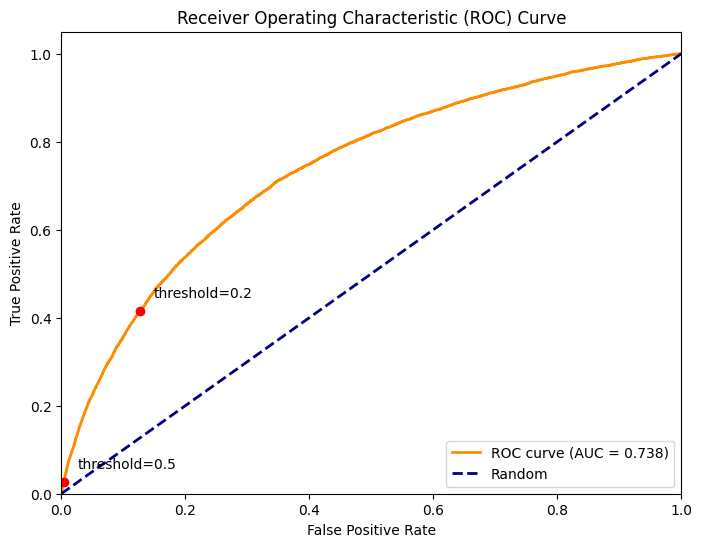

In [70]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [71]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[77948   289]
 [10236   282]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     78237
           1       0.49      0.03      0.05     10518

    accuracy                           0.88     88755
   macro avg       0.69      0.51      0.49     88755
weighted avg       0.84      0.88      0.83     88755


Confusion Matrix (threshold = 0.2):
[[68297  9940]
 [ 6148  4370]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     78237
           1       0.31      0.42      0.35     10518

    accuracy                           0.82     88755
   macro avg       0.61      0.64      0.62     88755
weighted avg       0.84      0.82      0.83     88755



## Baseline logistical regression model (all features)

In [72]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year',
                'year_x', 'year_y', 'quarter', 'month']
df = df_clean.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

AUC: 0.741


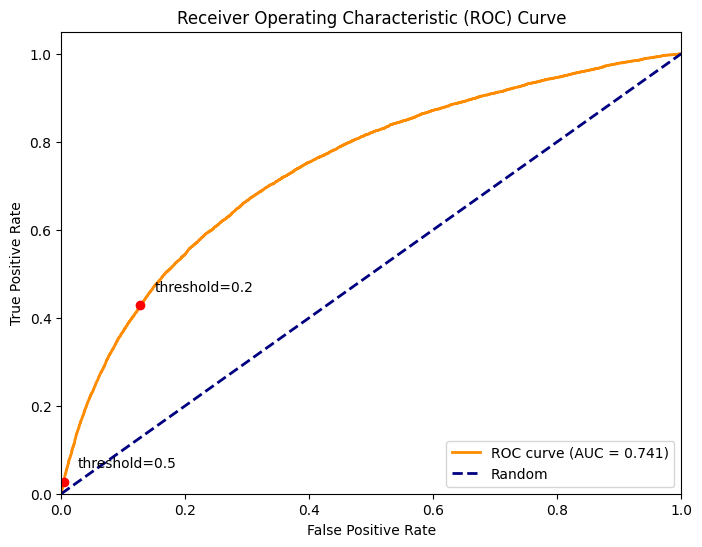

In [73]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [74]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[75675   312]
 [ 9719   274]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     75987
           1       0.47      0.03      0.05      9993

    accuracy                           0.88     85980
   macro avg       0.68      0.51      0.49     85980
weighted avg       0.84      0.88      0.83     85980


Confusion Matrix (threshold = 0.2):
[[66278  9709]
 [ 5712  4281]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     75987
           1       0.31      0.43      0.36      9993

    accuracy                           0.82     85980
   macro avg       0.61      0.65      0.63     85980
weighted avg       0.85      0.82      0.83     85980



In [75]:
# Print dataset info
print("\nDataset Information:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")
print("\nFeature names:")
print(feature_cols)


Dataset Information:
Training set size: 200611
Test set size: 85980
Number of features: 70

Feature names:
['Year_orig', 'Quarter_orig', 'orig_rt', 'orig_amt', 'oltv', 'ocltv', 'dti', 'cscore_b', 'mi_pct', 'num_bo', 'num_unit', 'HPI_state', 'FRM30_rate', 'treasury_3mon_rate', 'source_FD', 'source_FN', 'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'fthb_flg_N', 'fthb_flg_U', 'fthb_flg_Y']


## Improved logistic regression model (feature selection)



In [76]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).reset_index(drop=True)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [77]:
# 1. Base Logistic Regression Feature Importance
print("Method 1: Base Logistic Regression Feature Importance")
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_train_scaled, y_train)

importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': abs(base_model.coef_[0])
})
importance = importance.sort_values('coefficient', ascending=False)
print("\nTop 20 most important features:")
print(importance.head(20))

Method 1: Base Logistic Regression Feature Importance

Top 20 most important features:
               feature  coefficient
7             cscore_b     0.712985
9               num_bo     0.240006
11           HPI_state     0.197154
2              orig_rt     0.191745
12          FRM30_rate     0.191004
34            state_LA     0.120094
59            state_TX     0.098107
35            state_MA     0.084667
6                  dti     0.076233
8               mi_pct     0.075725
13  treasury_3mon_rate     0.065887
20            state_CA     0.051585
64            state_WI     0.050655
4                 oltv     0.047522
41            state_MS     0.043968
69          fthb_flg_Y     0.043640
67          fthb_flg_N     0.043279
25            state_FL     0.042217
15           source_FN     0.041750
14           source_FD     0.041750


In [78]:
# 2. LASSO Feature Selection
print("\nMethod 2: LASSO Feature Selection")
lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

lasso_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': abs(lasso.coef_)
})
lasso_selected = lasso_importance[lasso_importance['coefficient'] > 0]
print(f"\nLASSO selected {len(lasso_selected)} features")
print("\nTop 20 LASSO selected features:")
print(lasso_selected.sort_values('coefficient', ascending=False).head(20))


Method 2: LASSO Feature Selection

LASSO selected 68 features

Top 20 LASSO selected features:
               feature  coefficient
7             cscore_b     0.078963
9               num_bo     0.025087
2              orig_rt     0.024152
12          FRM30_rate     0.020245
11           HPI_state     0.016045
34            state_LA     0.014501
8               mi_pct     0.010542
59            state_TX     0.009690
67          fthb_flg_N     0.009191
14           source_FD     0.008803
35            state_MA     0.006752
41            state_MS     0.004878
25            state_FL     0.004871
13  treasury_3mon_rate     0.004764
20            state_CA     0.004357
6                  dti     0.004217
64            state_WI     0.003746
17            state_AL     0.003619
0            Year_orig     0.003234
56            state_SC     0.002738


In [79]:
# 3. Stepwise Selection using p-values
print("\nMethod 3: Stepwise Selection using p-values")
def stepwise_selection(X, y, initial_features, threshold_in=0.01, threshold_out=0.05):
    selected_features = initial_features.copy()
    changed = True

    while changed:
        changed = False
        # Backward elimination
        model = sm.Logit(y, sm.add_constant(X[selected_features])).fit(disp=0)
        pvalues = model.pvalues[1:]  # Exclude constant
        worst_feature = pvalues.index[pvalues.argmax()]

        if pvalues[worst_feature] > threshold_out:
            selected_features.remove(worst_feature)
            changed = True
            print(f'Removed: {worst_feature} (p-value: {pvalues[worst_feature]:.4f})')

    return selected_features

# Start with top 50 features from LASSO to speed up computation
initial_features = lasso_selected.sort_values('coefficient', ascending=False).head(50)['feature'].tolist()
stepwise_features = stepwise_selection(X_train_scaled, y_train, initial_features)

print("\nFeatures selected by stepwise selection:")
print(stepwise_features)


Method 3: Stepwise Selection using p-values
Removed: Year_orig (p-value: 0.7260)
Removed: ocltv (p-value: 0.2875)
Removed: state_PA (p-value: 0.2467)
Removed: state_ID (p-value: 0.2387)
Removed: fthb_flg_U (p-value: 0.1756)
Removed: state_NC (p-value: 0.1640)
Removed: state_IN (p-value: 0.1858)
Removed: state_TN (p-value: 0.1402)
Removed: state_KS (p-value: 0.1430)
Removed: state_DE (p-value: 0.0964)

Features selected by stepwise selection:
['cscore_b', 'num_bo', 'orig_rt', 'FRM30_rate', 'HPI_state', 'state_LA', 'mi_pct', 'state_TX', 'fthb_flg_N', 'source_FD', 'state_MA', 'state_MS', 'state_FL', 'treasury_3mon_rate', 'state_CA', 'dti', 'state_WI', 'state_AL', 'state_SC', 'state_OK', 'state_GA', 'num_unit', 'state_NH', 'state_AR', 'state_DC', 'orig_amt', 'oltv', 'state_WA', 'state_IL', 'state_WV', 'state_NY', 'Quarter_orig', 'state_MD', 'state_OH', 'state_CO', 'state_RI', 'state_VA', 'state_MI', 'state_MN', 'state_OR']


In [80]:
# Compare model performance with different feature sets
def evaluate_feature_set(X_train, X_test, y_train, y_test, features, name):
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train[features], y_train)
    y_pred_proba = model.predict_proba(X_test[features])[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} - AUC: {auc:.3f}")
    return auc

print("\nModel Performance Comparison:")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, "All Features")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, lasso_selected['feature'], "LASSO Selected")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, stepwise_features, "Stepwise Selected")


Model Performance Comparison:
All Features - AUC: 0.741
LASSO Selected - AUC: 0.741
Stepwise Selected - AUC: 0.741


np.float64(0.7409375173831495)

## Logistic regression model with best features

In [81]:
# Select best features from above
feature_cols = stepwise_features

# Filter out unneeded features
X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

AUC: 0.741


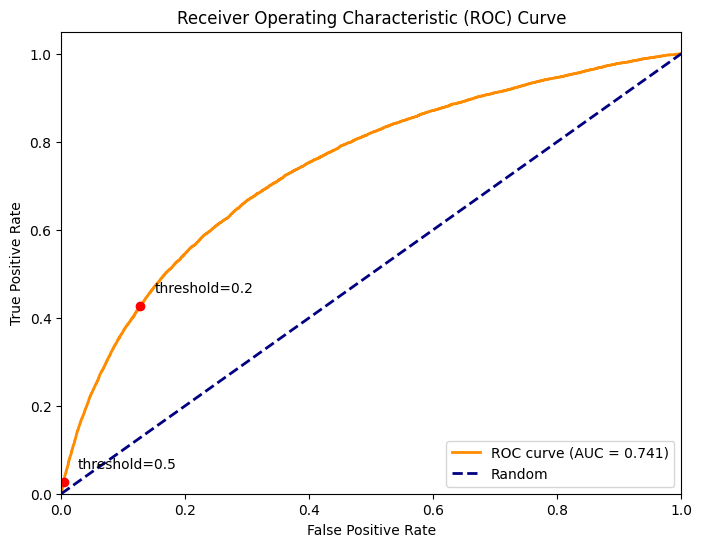

In [82]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [83]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[75679   308]
 [ 9728   265]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     75987
           1       0.46      0.03      0.05      9993

    accuracy                           0.88     85980
   macro avg       0.67      0.51      0.49     85980
weighted avg       0.84      0.88      0.83     85980


Confusion Matrix (threshold = 0.2):
[[66282  9705]
 [ 5728  4265]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     75987
           1       0.31      0.43      0.36      9993

    accuracy                           0.82     85980
   macro avg       0.61      0.65      0.63     85980
weighted avg       0.85      0.82      0.83     85980



In [84]:
# Print dataset info
print("\nDataset Information:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")
print("\nFeature names:")
print(feature_cols)


Dataset Information:
Training set size: 200611
Test set size: 85980
Number of features: 40

Feature names:
['cscore_b', 'num_bo', 'orig_rt', 'FRM30_rate', 'HPI_state', 'state_LA', 'mi_pct', 'state_TX', 'fthb_flg_N', 'source_FD', 'state_MA', 'state_MS', 'state_FL', 'treasury_3mon_rate', 'state_CA', 'dti', 'state_WI', 'state_AL', 'state_SC', 'state_OK', 'state_GA', 'num_unit', 'state_NH', 'state_AR', 'state_DC', 'orig_amt', 'oltv', 'state_WA', 'state_IL', 'state_WV', 'state_NY', 'Quarter_orig', 'state_MD', 'state_OH', 'state_CO', 'state_RI', 'state_VA', 'state_MI', 'state_MN', 'state_OR']


## Test different models with best features

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [86]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year',
                'year_x', 'year_y', 'quarter', 'month']
df = df_clean.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [87]:
# Use only recommended features
recommended_features = stepwise_features
X_train_selected = X_train_scaled[recommended_features]
X_test_selected = X_test_scaled[recommended_features]

In [88]:
# Dictionary to store results
model_results = {}

In [89]:
# Logistic Regression
print("Tuning Logistic Regression...")
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000],
    'penalty': ['none', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=5, n_jobs=-1)
lr_grid.fit(X_train_selected, y_train)

print(f"Best LR parameters: {lr_grid.best_params_}")
lr_pred_proba = lr_grid.predict_proba(X_test_selected)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred_proba)
model_results['Logistic Regression'] = {
    'auc': lr_auc,
    'best_params': lr_grid.best_params_,
    'model': lr_grid.best_estimator_
}
print(model_results['Logistic Regression'])

Tuning Logistic Regression...
Best LR parameters: {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
{'auc': np.float64(0.7410208228313414), 'best_params': {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}, 'model': LogisticRegression(C=0.001, max_iter=1000, random_state=42, solver='liblinear')}


In [90]:
# 2. Random Forest
print("\nTuning Random Forest...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=5, n_jobs=-1)
rf_grid.fit(X_train_selected, y_train)

print(f"Best RF parameters: {rf_grid.best_params_}")
rf_pred_proba = rf_grid.predict_proba(X_test_selected)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)
model_results['Random Forest'] = {
    'auc': rf_auc,
    'best_params': rf_grid.best_params_,
    'model': rf_grid.best_estimator_
}
print(model_results['Random Forest'])


Tuning Random Forest...
Best RF parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}
{'auc': np.float64(0.7367586265338557), 'best_params': {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}, 'model': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)}


In [94]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [95]:
# 3. Neural Network
print("\nTraining Neural Network...")
K.clear_session()
text_input = Input(shape=(X_train_selected.shape[1],))
hidden_state = Dense(
    32,
    activation="relu",
    kernel_regularizer=l2(1e-4),
)(text_input)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(
    16,
    activation="relu",
)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(1, activation="sigmoid")(hidden_state)
nn_model = Model(text_input, output)
nn_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
nn_model.summary()


Training Neural Network...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Train the model with early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

history = nn_model.fit(
    X_train_selected, 
    y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - acc: 0.7546 - loss: 0.5280 - val_acc: 0.8780 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - acc: 0.8820 - loss: 0.3433 - val_acc: 0.8781 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - acc: 0.8826 - loss: 0.3362 - val_acc: 0.8781 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - acc: 0.8826 - loss: 0.3344 - val_acc: 0.8782 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - acc: 0.8814 - loss: 0.3333 - val_acc: 0.8782 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - acc: 0.8836 - loss: 0.3288 - val_acc: 0.8780 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - acc: 0.8829 - loss: 0.3276 - val_acc: 0.8779 - val_loss: 0.3288 - learning_rate:

In [97]:
# Get predictions
nn_pred_proba = nn_model.predict(X_test_selected, verbose=0)
nn_auc = roc_auc_score(y_test, nn_pred_proba)
model_results['Neural Network'] = {
    'auc': nn_auc,
    'best_params': {
        'hidden1_units': 32,
        'hidden2_units': 16,
        'dropout_rate': 0.2,
        'l2_reg': 1e-4,
        'epochs': 50,
        'batch_size': 256
    },
    'model': nn_model
}
print(model_results['Neural Network'])

{'auc': np.float64(0.7400607774857431), 'best_params': {'hidden1_units': 32, 'hidden2_units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'epochs': 50, 'batch_size': 256}, 'model': <Functional name=functional, built=True>}


### Compare results of different models

In [98]:
# Compare results
print("\nModel Comparison:")
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'AUC': [results['auc'] for results in model_results.values()]
}).sort_values('AUC', ascending=False)
print(results_df)

# Get best model
best_model_name = results_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {model_results[best_model_name]['best_params']}")


Model Comparison:
                 Model       AUC
0  Logistic Regression  0.741021
2       Neural Network  0.740061
1        Random Forest  0.736759

Best Model: Logistic Regression
Best Parameters: {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


In [99]:
# Generate predictions using different thresholds for best model
thresholds = [0.2, 0.5]
for threshold in thresholds:
    print(f"\nClassification Report for {best_model_name} (threshold = {threshold}):")
    y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(classification_report(y_test, y_pred))


Classification Report for Logistic Regression (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     75987
           1       0.30      0.46      0.36      9993

    accuracy                           0.81     85980
   macro avg       0.61      0.66      0.62     85980
weighted avg       0.85      0.81      0.83     85980


Classification Report for Logistic Regression (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     75987
           1       0.48      0.02      0.04      9993

    accuracy                           0.88     85980
   macro avg       0.68      0.51      0.49     85980
weighted avg       0.84      0.88      0.83     85980



In [100]:
# Feature importance for best model (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\nFeature Importances:")
    importances = pd.DataFrame({
        'feature': list(recommended_features),
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importances)
elif hasattr(best_model, 'coef_'):
    print("\nFeature Coefficients:")
    importances = pd.DataFrame({
        'feature': list(recommended_features),
        'coefficient': abs(best_model.coef_[0])
    }).sort_values('coefficient', ascending=False)
    print(importances)


Feature Coefficients:
               feature  coefficient
0             cscore_b     0.635241
1               num_bo     0.213482
2              orig_rt     0.133270
4            HPI_state     0.130273
3           FRM30_rate     0.130040
5             state_LA     0.100371
6               mi_pct     0.075579
8           fthb_flg_N     0.073528
7             state_TX     0.071030
9            source_FD     0.070408
15                 dti     0.068669
26                oltv     0.059090
10            state_MA     0.055273
13  treasury_3mon_rate     0.053435
16            state_WI     0.047367
14            state_CA     0.039995
11            state_MS     0.034970
12            state_FL     0.034930
25            orig_amt     0.032378
27            state_WA     0.029058
33            state_OH     0.027982
21            num_unit     0.026919
17            state_AL     0.025765
28            state_IL     0.025610
22            state_NH     0.022420
32            state_MD     0.021097
34   

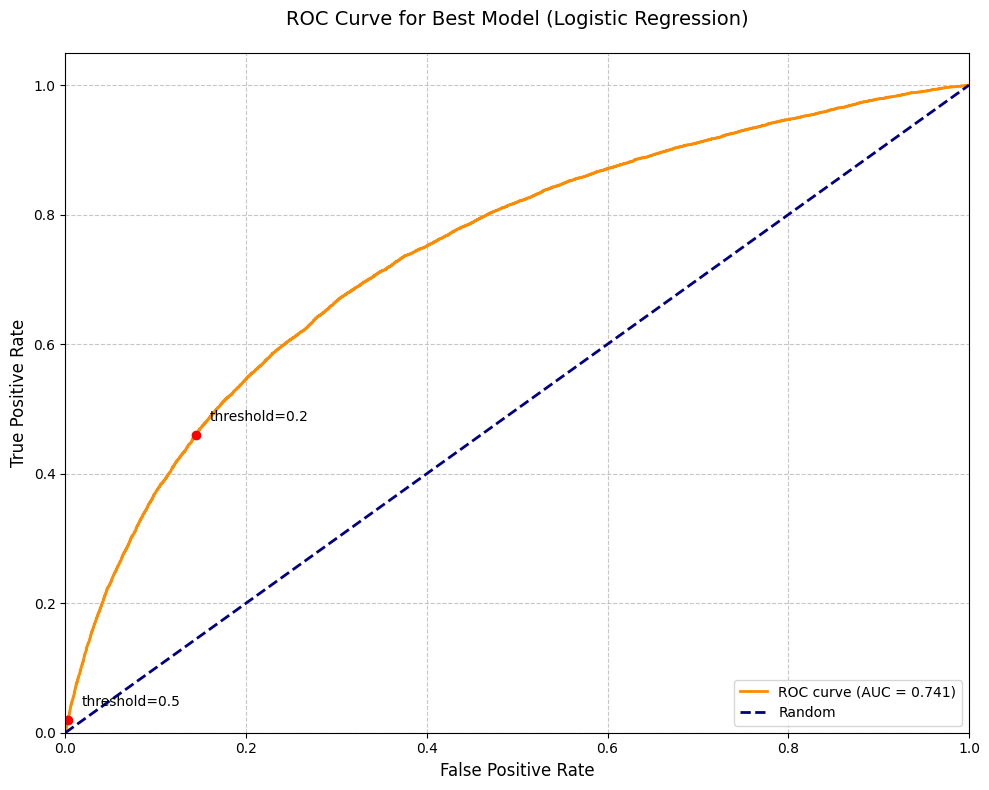

Best Model: Logistic Regression
AUC Score: 0.741


In [103]:
# Get predicted probabilities from best model
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for best model
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Add details to make the plot more informative
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Best Model (Logistic Regression)', fontsize=14, pad=20)
plt.legend(loc="lower right", fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show classification thresholds
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

print(f"Best Model: Logistic Regression")
print(f"AUC Score: {roc_auc:.3f}")

## Use expanding validation window

In [104]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [105]:
# Prepare data
df_full = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_full['Year_orig'] = X_train['Year_orig']  # Add back the year
df_full['target'] = y_train

# Get unique years for expanding window
years = sorted(df_full['Year_orig'].unique())
print("Available years:", years)

Available years: [np.float64(nan), np.float64(2000.0), np.float64(2001.0), np.float64(2002.0), np.float64(2003.0), np.float64(2004.0), np.float64(2005.0), np.float64(2006.0)]


In [106]:
# Dictionary to store results for each model
model_results = {
    'Logistic Regression': {'yearly_auc': {}},
    'Random Forest': {'yearly_auc': {}},
    'Neural Network': {'yearly_auc': {}}
}

# For each test year (except the first two years which we'll use as initial training)
for i, test_year in enumerate(years[2:], 2):
    print(f"\nTest Year: {test_year}")
    
    # Get train and test data
    train_years = years[:i]
    train_mask = df_full['Year_orig'].isin(train_years)
    test_mask = df_full['Year_orig'] == test_year
    
    # Select features (excluding Year_orig and target)
    feature_cols = stepwise_features
    
    X_train_year = df_full[train_mask][feature_cols]
    y_train_year = df_full[train_mask]['target']
    X_test_year = df_full[test_mask][feature_cols]
    y_test_year = df_full[test_mask]['target']
    
    print(f"Training on years: {train_years}")
    print(f"Training size: {len(X_train_year)}, Test size: {len(X_test_year)}")
    
    # 1. Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_year, y_train_year)
    lr_pred = lr.predict_proba(X_test_year)[:, 1]
    lr_auc = roc_auc_score(y_test_year, lr_pred)
    model_results['Logistic Regression']['yearly_auc'][test_year] = lr_auc
    
    # 2. Random Forest
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_train_year, y_train_year)
    rf_pred = rf.predict_proba(X_test_year)[:, 1]
    rf_auc = roc_auc_score(y_test_year, rf_pred)
    model_results['Random Forest']['yearly_auc'][test_year] = rf_auc
    
    # 3. Neural Network
    K.clear_session()
    text_input = Input(shape=(X_train_year.shape[1],))
    hidden_state = Dense(32, activation="relu", kernel_regularizer=l2(1e-4))(text_input)
    hidden_state = Dropout(0.2)(hidden_state)
    hidden_state = Dense(16, activation="relu")(hidden_state)
    hidden_state = Dropout(0.2)(hidden_state)
    output = Dense(1, activation="sigmoid")(hidden_state)
    nn_model = Model(text_input, output)
    nn_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
    
    nn_model.fit(X_train_year, y_train_year, epochs=50, batch_size=256, verbose=0)
    nn_pred = nn_model.predict(X_test_year, verbose=0)
    nn_auc = roc_auc_score(y_test_year, nn_pred)
    model_results['Neural Network']['yearly_auc'][test_year] = nn_auc
    
    # Print year results
    print(f"\nAUC scores for year {test_year}:")
    print(f"Logistic Regression: {lr_auc:.3f}")
    print(f"Random Forest: {rf_auc:.3f}")
    print(f"Neural Network: {nn_auc:.3f}")


Test Year: 2001.0
Training on years: [np.float64(nan), np.float64(2000.0)]
Training size: 29496, Test size: 39539

AUC scores for year 2001.0:
Logistic Regression: 0.499
Random Forest: 0.492
Neural Network: 0.503

Test Year: 2002.0
Training on years: [np.float64(nan), np.float64(2000.0), np.float64(2001.0)]
Training size: 69035, Test size: 15390

AUC scores for year 2002.0:
Logistic Regression: 0.497
Random Forest: 0.484
Neural Network: 0.505

Test Year: 2003.0
Training on years: [np.float64(nan), np.float64(2000.0), np.float64(2001.0), np.float64(2002.0)]
Training size: 84425, Test size: 13029

AUC scores for year 2003.0:
Logistic Regression: 0.497
Random Forest: 0.501
Neural Network: 0.497

Test Year: 2004.0
Training on years: [np.float64(nan), np.float64(2000.0), np.float64(2001.0), np.float64(2002.0), np.float64(2003.0)]
Training size: 97454, Test size: 11754

AUC scores for year 2004.0:
Logistic Regression: 0.509
Random Forest: 0.499
Neural Network: 0.507

Test Year: 2005.0
Train


Final Results:
                 Model  Mean AUC   Std AUC
2       Neural Network  0.504356  0.005733
0  Logistic Regression  0.500385  0.004253
1        Random Forest  0.498004  0.009180


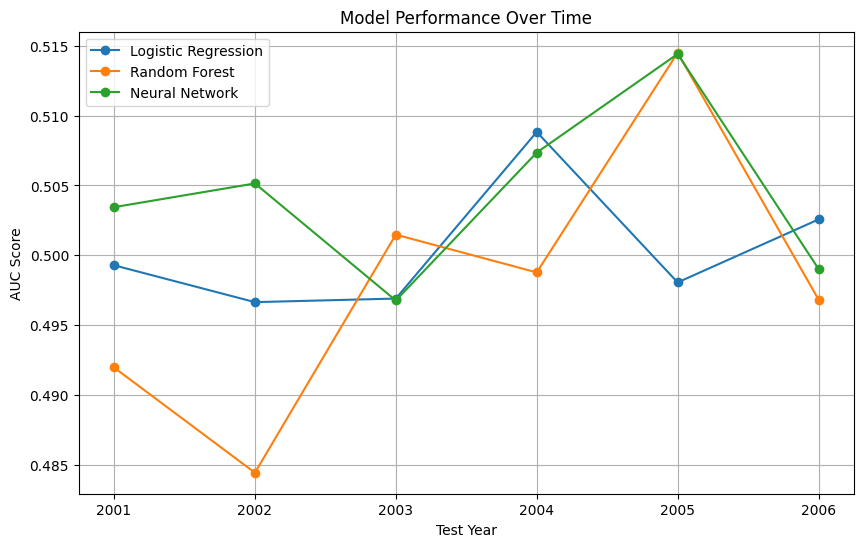

In [107]:
# Calculate average AUC for each model
for model_name in model_results:
    yearly_aucs = list(model_results[model_name]['yearly_auc'].values())
    model_results[model_name]['mean_auc'] = np.mean(yearly_aucs)
    model_results[model_name]['std_auc'] = np.std(yearly_aucs)

# Print final results
print("\nFinal Results:")
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Mean AUC': [results['mean_auc'] for results in model_results.values()],
    'Std AUC': [results['std_auc'] for results in model_results.values()]
}).sort_values('Mean AUC', ascending=False)
print(results_df)

# Plot yearly performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model_name in model_results:
    yearly_aucs = model_results[model_name]['yearly_auc']
    plt.plot(list(yearly_aucs.keys()), list(yearly_aucs.values()), marker='o', label=model_name)

plt.xlabel('Test Year')
plt.ylabel('AUC Score')
plt.title('Model Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()